df                        index       swi                                \
                       index  delta-g1  delta-g2  theta-g1  theta-g2   
39  Active-Hemlata-PrevsPost  0.129809  0.100860  0.886666  0.882582   
40    Active-Malti-PrevsPost  0.298399  0.044857  0.254880  0.040832   
41   Active-Preeti-PrevsPost  0.904868  0.969947  0.878123  0.887569   
42  Active-Sharifa-PrevsPost  0.916941  1.000000  0.086164  0.032510   
43   Active-Vinita-PrevsPost  0.437500  0.117033  0.297387  0.059630   
44      Active-VKS-PrevsPost  0.092593  0.074479  0.437500  0.105174   
45     Active-Nitu-PrevsPost  0.060689  0.020407       NaN       NaN   
46  Active-Ranjeet-PrevsPost  0.482946  0.072658  0.528402  0.368869   
47   Active-Resham-PrevsPost       NaN       NaN  0.471295  0.288429   
48   Active-Rithik-PrevsPost  0.898379  0.613415  0.346965  0.322847   
49    Active-Rohan-PrevsPost  0.373334  0.065833  0.376202  0.032329   
50    Active-Suman-PrevsPost  0.430875  0.276457  0.371397  0

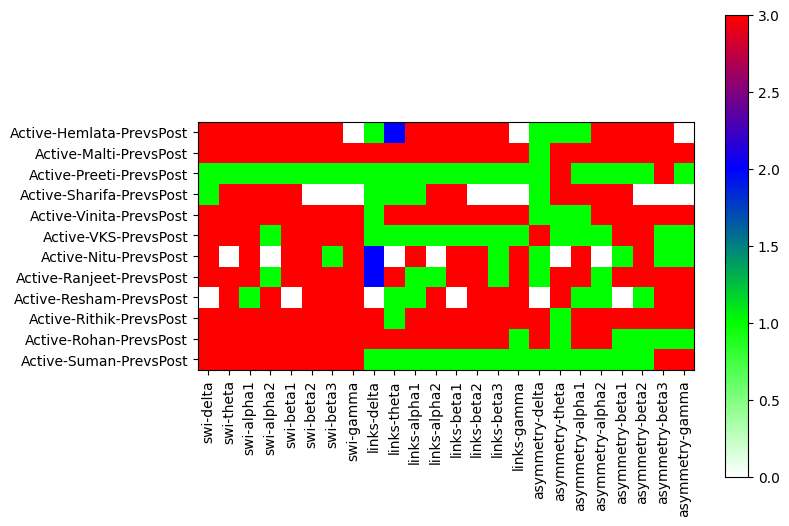

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm
import statsmodels.formula.api as smf
# from tabulate import tabulate



ACTIVE_SHAM = 'Active'

existing_file = f"comparison-results/result-{ACTIVE_SHAM}.xlsx"
df = pd.read_excel(existing_file, header=[0,1])
df_without_rows = df.drop(df.index[0:len(df)//2+14])
df_without_columns = df_without_rows.drop(df_without_rows.columns[0:len(df)//2+1], axis=1)
df = df_without_columns
print("df", df)

colors = [(1, 1, 1), (0, 1, 0),  (0, 0, 1), (1, 0, 0)] # white, green, blue, red
values = [0, 1, 2, 3]
cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, N=256)

# 0 : If swi values NaN ----- white
# 1 : If post swi > pre swi, post links > pre links, post asymmetry < pre asymmetry ----- green
# 2 : If post swi == pre swi, |post links - pre links| < 3, post asymmetry == pre asymmetry ---- blue
# 3 : If post swi < pre swi, post links < pre links, post asymmetry > pre asymmetry ----- red

condition_matrix = np.zeros((len(df), (len(df.columns) -8) // 2))
for j in range(len(df)): # rows
    insignificant_bands  = []
    for i in range(1, len(df.columns)-8, 2): # cols    
        if i in range(0,16):
            if np.isnan(df.iloc[j, i]):
                condition_matrix[j, i // 2] = 0 # white
                insignificant_bands.append(i)
            # else:
            elif df.iloc[j, i] < df.iloc[j, i + 1]: 
                condition_matrix[j, i // 2] = 1 # green
            elif np.abs(df.iloc[j, i] - df.iloc[j, i + 1]) == 0:
                condition_matrix[j, i // 2] = 2 # blue
                # insignificant_bands.append(i)
            else:
                condition_matrix[j, i // 2] = 3 # red
        elif i in range(16,32):
            if i-16 in insignificant_bands:
                condition_matrix[j, i // 2] = 0 # white
            elif df.iloc[j, i] < df.iloc[j, i + 1]:
                condition_matrix[j, i // 2] = 1 # green 
            elif np.abs(df.iloc[j, i] - df.iloc[j, i + 1]) <= 5: # links difference <= 5
                condition_matrix[j, i // 2] = 2 # blue
            else:
                condition_matrix[j, i // 2] = 3 # red
        elif i in range(32,48):
            if i-32 in insignificant_bands:
                condition_matrix[j, i // 2] = 0 # white
            # else:
            elif np.abs(df.iloc[j, i] - 1) > np.abs(df.iloc[j, i+1] - 1): 
                condition_matrix[j, i//2] = 1 # green
            elif np.abs(df.iloc[j, i] - 1) == np.abs(df.iloc[j, i+1] - 1): 
                condition_matrix[j, i//2] = 2 # blue
            else:
                condition_matrix[j, i//2] = 3 # red

lis = [f"{df.columns[i][0]}-{df.columns[i][1].split('-')[0]}" for i in range(1, len(df.columns)-8, 2)]

plt.figure(figsize=(8, 6))
plt.imshow(condition_matrix, cmap=cmap)
plt.xticks(range(((len(df.columns)-8)// 2)), lis, rotation='vertical')
plt.yticks(range(len(df)), list(df.iloc[:, 0]))
plt.colorbar()
plt.show()

In [3]:
existing_file = f"comparison-results/result-Active.xlsx"
df = pd.read_excel(existing_file, header=[0,1])
df_without_rows = df.drop(df.index[0:len(df)//2+1])
df_without_columns = df_without_rows.drop(df_without_rows.columns[0:len(df)//2+1], axis=1)
active_data = df_without_columns
existing_file = f"comparison-results/result-Sham.xlsx"
df = pd.read_excel(existing_file)
df_without_rows = df.drop(df.index[0:len(df)//2+1])
df_without_columns = df_without_rows.drop(df_without_rows.columns[0:len(df)//2+1], axis=1)
sham_data = df_without_columns

combined_data = pd.concat([active_data, sham_data], axis=0)


# Add the new row to the DataFrame
for index, row in active_data.iterrows():
    # print(f"Row {index}:\n{row}\n")
    print(len(active_data))
    active_data.loc[len(active_data)] = row

print(active_data)

# Assuming 'combined_data' is your DataFrame
# print(tabulate(combined_data, headers='keys', tablefmt='psql'))


# # Create a DataFrame with your data
# data = {
#     'group': ['active']*12 + ['placebo']*6,
#     'small_worldedness': [1.2, 1.3, 1.4, 1.1, 1.5, 1.6, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3],
#     'num_links': [100, 110, 95, 105, 115, 90, 100, 110, 95, 105, 100, 110, 95, 105, 100, 110, 95, 105, 100, 110],
#     'asymmetry': [0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2],
#     'brain_region': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B']
# }
# df = pd.DataFrame(data)

# # Fit a linear regression model
# model = smf.ols(formula='small_worldedness ~ group + num_links + asymmetry + brain_region', data=df)
# results = model.fit()

# # Print the regression results
# print(results.summary())


# Assuming you have loaded the data into DataFrames active_data and sham_data

# Combine the data into a single DataFrame

# # Assume 'SWI' is the dependent variable and 'freq_band_1_g1' and 'freq_band_1_g2' are independent variables
# X = combined_data[['freq_band_1_g1', 'freq_band_1_g2']]
# X = sm.add_constant(X)  # Add a constant term to the independent variables
# y = combined_data['SWI']

# # Fit the linear regression model
# model = sm.OLS(y, X).fit()

# # Print the model summary
# print(model.summary())


25
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
                       index       swi                                \
                       index  delta-g1  delta-g2  theta-g1  theta-g2   
26    Active-Suman-PrevsPost  0.430875  0.276457  0.371397  0.174822   
27    Active-Malti-PrevsPost  0.298399  0.044857  0.254880  0.040832   
28   Active-Preeti-PrevsPost  0.904868  0.969947  0.878123  0.887569   
29  Active-Sharifa-PrevsPost  0.916941  1.000000  0.086164  0.032510   
30   Active-Vinita-PrevsPost  0.437500  0.117033  0.297387  0.059630   
31      Active-VKS-PrevsPost  0.092593  0.074479  0.437500  0.105174   
32     Active-Nitu-PrevsPost  0.060689  0.020407       NaN       NaN   
33  Active-Ranjeet-PrevsPost  0.482946  0.072658  0.528402  0.368869   
34   Active-Resham-PrevsPost       NaN       NaN  0.471295  0.288429   
35   Active-Rithik-PrevsPost  0.898379  0.613415  0.346965  0.322847   
36    Active-Rohan-PrevsPost  0.373334  0.065833  0.376202  0